In [2]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [3]:
# Initial abundances are Anders & Grevesse 1989,taken from Umeda 1999. Y is also specified there (nomoto_helium function)

# Loading the solar abundances
from Chempy import solar_abundance
basic_solar_AG = solar_abundance.solar_abundances()
basic_solar_AG.AG89()

# We initialise the primordial infall routine
from Chempy.infall import PRIMORDIAL_INFALL
solar_scaled_material = PRIMORDIAL_INFALL(list(basic_solar_AG.all_elements),np.copy(basic_solar_AG.table))\
# and ask to give back the fractions of solar scaled material with [FE/H] = -0.3 dex
solar_scaled_material.solar(-0.3, 0.274)

# Loading the chieffi yield table
from Chempy.yields import SN2_feedback
nomoto = SN2_feedback()
getattr(nomoto, 'Nomoto2013')()

/home/philcox/anaconda3/lib/python3.6/site-packages/numpy/core/records.py:507: FutureWarning: Numpy has detected that you may be viewing or writing to an array returned by selecting multiple fields in a structured array. 

This code may break in numpy 1.13 because this will return a view instead of a copy -- see release notes for details.
  return obj.view(dtype=(self.dtype.type, obj.dtype))


In [4]:
print(nomoto.metallicities)

[0.05, 0.02, 0.008, 0.004, 0.001]


In [5]:
def nomoto_helium(metallicity, helium_primordial = 0.247, dydz = 1.5265, zsolar = 0.27753):
    # as specified in Umeda 1999. Only valid for z <= 0.02
    helium = helium_primordial + metallicity * dydz
    return(helium)
for item in nomoto.metallicities:
    print(item, nomoto_helium(item))

0.05 0.323325
0.02 0.27753
0.008 0.259212
0.004 0.253106
0.001 0.24852649999999998


In [6]:
# This routine makes net yield from the gross yields, i.e. subtracts the unprocessed solar scaled material that is implicitely mixed into the expelled material

# helium fraction corresponding to the different metallicities as taken from Umeda 1999
# For Chieffi 2004 we would need
# met = [0,1e-6,1e-4,1e-3,6e-3,2e-2]
# helium = [0.23,0.23,0.23,0.23,0.26,0.285]
# For nomoto met = [0.05, 0.02, 0.008, 0.004, 0.001]
helium_frac = [0.3,0.27753,0.259212,0.253106,0.2485265]
met_tables = []

# Iterating over metallicities
for i,met in enumerate(nomoto.metallicities):
    
    # Creating an empty table like the yield table
    net_table = np.zeros_like(nomoto.table[met])
    net_table['Mass'] = nomoto.table[met]['Mass']
    net_table['mass_in_remnants'] = nomoto.table[met]['mass_in_remnants']
    
    # Iterating over the masses of the stars
    for j,mass in enumerate(nomoto.table[met]["Mass"]):
        
        # Producing solar scaled material of the specific metallicity
        if met != 0.:
            solar_scaled_material.solar(np.log10(met/basic_solar_AG.z), helium_frac[i])
        else:
            solar_scaled_material.solar(np.log10(0.0000000000000001/basic_solar_AG.z), helium_frac[i])
        
        # Using the same array element order as in the chieffi table
        sol_frac = []
        for element in nomoto.elements:
            sol_frac.append(float(solar_scaled_material.fractions[np.where(np.array(basic_solar_AG.all_elements)==element)]))
        sol_frac = np.array(sol_frac)           
        
        # Normalising the sol fractions to the same mass as the outflow
        outflow_mass = sum(list(nomoto.table[met][nomoto.elements][j]))
        sol_frac *= outflow_mass
        outflow = np.array(list(nomoto.table[met][nomoto.elements][j]))
        
        # The net yields equals the total outflow of an element minus the solar scaled abundances that would have been expelled if no nucleosynthesis was at work
        net_yield = outflow - sol_frac
        
        # rescale the unprocessed mass in winds such that it adds to one together with the remnant and the net_yield (which not equals 0 due to rounding errors)
        net_table['unprocessed_mass_in_winds'][j] = 1 - nomoto.table[met]['mass_in_remnants'][j] - sum(net_yield)
        
        # Assigning the net_yield to the new table element by element
        for el_i,element in enumerate(nomoto.elements):
            net_table[j][element] = net_yield[el_i]
    
    # Adding the net yield table for a specific metallicity to a list containing all in the end
    met_tables.append(net_table)
    # to produce net yields uncomment the next line and save the files in the input/yields/nomoto2013 folder
    #np.save("nomoto_net_met_ind_%d" %(i), net_table)

/home/philcox/anaconda3/lib/python3.6/site-packages/numpy/core/records.py:507: FutureWarning: Numpy has detected that you may be viewing or writing to an array returned by selecting multiple fields in a structured array. 

This code may break in numpy 1.13 because this will return a view instead of a copy -- see release notes for details.
  return obj.view(dtype=(self.dtype.type, obj.dtype))


In [7]:
# Loading a second instance of the nomoto yields
nomoto_net = SN2_feedback()
getattr(nomoto_net, 'Nomoto2013')()

# Replacing the gross yield tables by net yield tables
for i,met in enumerate(nomoto.metallicities):
    nomoto_net.table[met] = met_tables[i]

/home/philcox/anaconda3/lib/python3.6/site-packages/numpy/core/records.py:507: FutureWarning: Numpy has detected that you may be viewing or writing to an array returned by selecting multiple fields in a structured array. 

This code may break in numpy 1.13 because this will return a view instead of a copy -- see release notes for details.
  return obj.view(dtype=(self.dtype.type, obj.dtype))


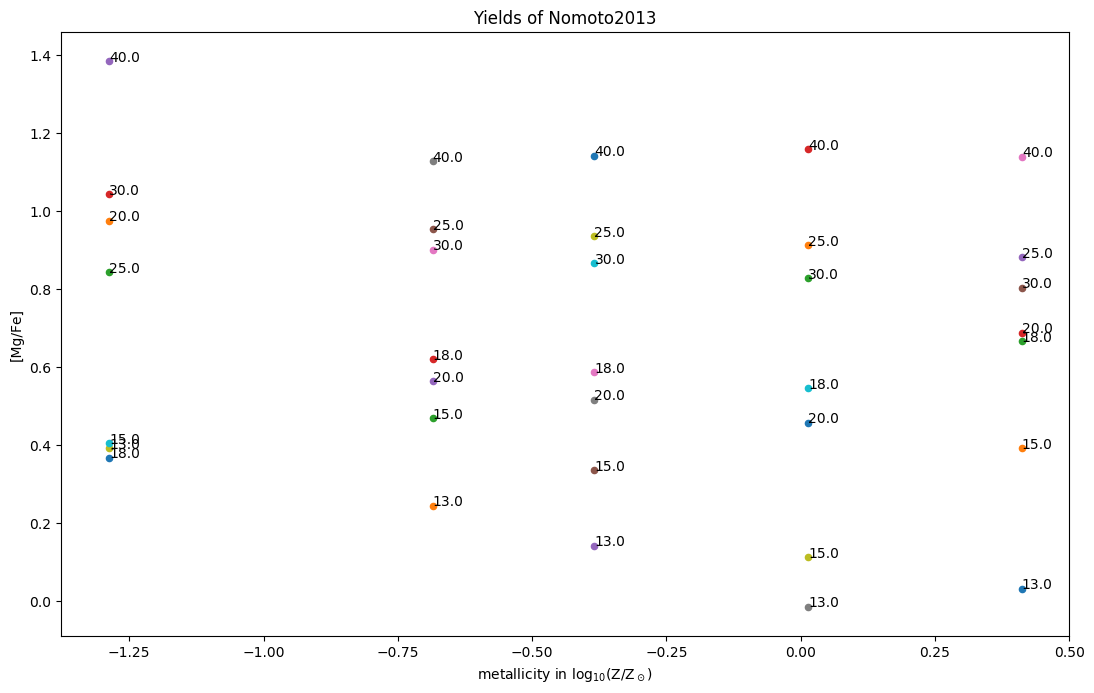

In [7]:
# Comparing the output - looks reasonable
from Chempy.data_to_test import yield_plot
element = 'Mg'
yield_plot('Nomoto2013', nomoto, basic_solar_AG, element)

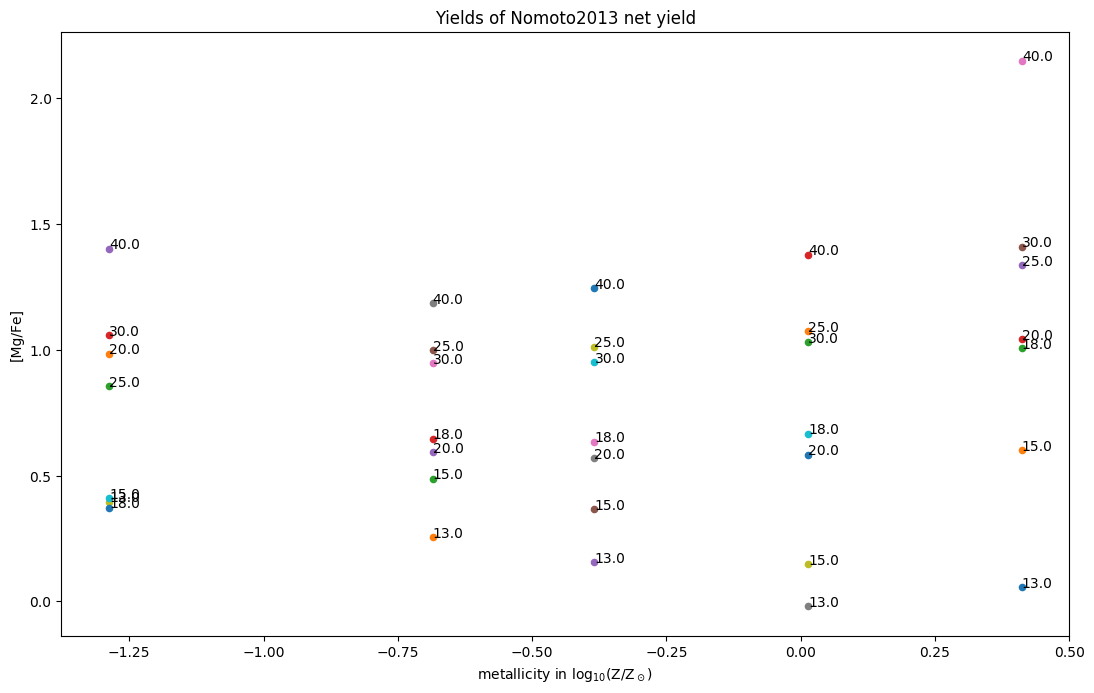

In [8]:
yield_plot('Nomoto2013 net yield', nomoto_net, basic_solar_AG, element)

In [9]:
nomoto_net = SN2_feedback()
getattr(nomoto_net, 'Nomoto2013_net')()

In [10]:
yield_plot('Nomoto2013 net yield', nomoto_net, basic_solar_AG, element)

NameError: name 'yield_plot' is not defined

In [11]:
dat = np.load('Chempy/input/yields/Nomoto2013/nomoto_net_met_ind_2.npy')

In [12]:
dat

array([ ( 13.,  0.12353846,  0.87646136, -0.14824092,  0.09580083,  -3.53324518e-09,  -5.91303953e-11,  -2.02166654e-09,  0.00635425,  0.00159847,  0.02093865,   3.84700746e-07,  0.00651117,   8.39777556e-05,  0.00279363,  0.00012634,  0.00505793,   1.68216473e-05,  0.00236179,   4.76107271e-06,  0.00039938,   1.39432576e-06,  0.00031449,   1.95152558e-08,   6.32502144e-06,   8.37492971e-07,   7.06401970e-05,   1.47190918e-05,  0.00552639,   1.20295487e-05,   2.34908325e-04,   1.31437338e-06,   9.19502165e-06,   1.16599207e-07,   3.46890743e-07),
       ( 15.,  0.1       ,  0.89999982, -0.15968159,  0.11762171,  -3.49726518e-09,  -5.84977700e-11,  -1.99732565e-09,  0.00417651,  0.00187088,  0.01250898,   3.82031502e-07,  0.00517275,   4.94584692e-05,  0.00392915,  0.00017595,  0.00629879,   2.85250474e-05,  0.00226743,   5.61104510e-06,  0.00030605,   2.21241147e-06,  0.00021242,   2.21418896e-08,   5.78553516e-06,   5.23758599e-07,   7.43051055e-05,   1.40640056e-05,  0.00479276,   6.

In [17]:
tot=0
for i in range(len(nomoto.table[0.02][2])):
    if i > 1:
        tot+=nomoto.table[0.02][2][i]

In [20]:
nomoto.table[0.02][2]

(18.0, 0.08777777777777779, 0.06893769393998994, 0.41811666666666664, 0.3396572111111111, 1.5550015453333334e-14, 4.2023333333333334e-19, 4.3494444444444443e-11, 0.007637888888888889, 0.0036731816111111107, 0.043495492777777776, 2.485166666666667e-07, 0.008677917222222222, 0.00016285, 0.006423311111111111, 0.0005568888888888889, 0.006375311111111111, 9.674444444444444e-05, 0.002193084388888889, 1.2863166666666666e-05, 0.00034779575555555554, 4.693594444444445e-06, 0.00025682192277777776, 7.00388888888889e-08, 8.728361111111111e-06, 6.372203888888889e-07, 7.935116666666667e-05, 2.248888888888889e-05, 0.00516533611111111, 1.0109444444444444e-05, 0.0003014826666666667, 1.481477777777778e-06, 5.183642777777777e-06, 1.0954666666666667e-07, 5.78495e-07)